In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [3]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [4]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [5]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [6]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [7]:
class MAForecast(object):
    
    def __init__(self, df, percentage_train_size, periodicity, box_cox):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.periodicity = periodicity
        self.box_cox = box_cox
        self.fitted_lambda = 0
        
    def perform(self):
        
        best_params, train_size, y_train_predict = self.grid_search_model()
                
        array_pred = np.array([])
        
        date_test = self.df[train_size:].index
        count = 0
        total = len(date_test)
                
        for current_datetime in date_test:

            pred = self.prediction(best_params = best_params, current_datetime = current_datetime)
            array_pred = np.append(array_pred, pred)
#             print('current_datetime ->', current_datetime)
#             print('pred ->', pred)
#             print('---')
            count += 1
            print(round(count/total*100, 2))
        print('---')
    
        if self.box_cox:
            print('box_cox', self.box_cox)
            array_pred = inv_boxcox(array_pred, self.fitted_lambda)
            self.df['Close'] = inv_boxcox(self.df['Close'], self.fitted_lambda)

        date_train = self.df[:train_size].index
#         date_train = y_train_predict.index
        y_train = self.df[:train_size]['Close'].values
        
        date_test = self.df[train_size:].index
        y_test = self.df[train_size:]['Close'].values
        
        data_train = {
          'date_train': date_train,
          'y_train': y_train,
          'y_train_predict': y_train_predict.values
        }

        data_test = {
            'date_test': date_test,
            'y_test': y_test,
            'y_test_predict': array_pred
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_test['y_test'],
                                                                        df_test['y_test_predict'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        return df_train, df_test
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_params, current_datetime):
        
        p = best_params['p_order']
        d = best_params['d_order']
        q = best_params['q_order']

        if self.periodicity == '1_day':
            train_datetime = (current_datetime - pd.Timedelta(days = 1))

        if self.periodicity == '1_hour':
            train_datetime = (current_datetime - pd.Timedelta(hours = 1))

        model = sm.tsa.statespace.SARIMAX(self.df[:train_datetime], order = (p, d, q), initialization='approximate_diffuse')
        fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)
        
        pred = fit_model.predict(start = current_datetime, end = current_datetime)
        
        return pred
        
    def grid_search_model(self):
        
        train_size = int(len(self.df) * self.percentage_train_size)
        
        if self.box_cox:
            print('box_cox', self.box_cox)
            fitted_data, fitted_lambda = boxcox(self.df['Close'])
            self.df['Close'] = fitted_data
            self.fitted_lambda = fitted_lambda
        
        best_aic = np.inf 
        best_params = None
        best_fit = None

        q_range = range(6)
        d_range = range(3) # [0,1,2]
        
        for d in d_range:
            
            n_diff = 0
            X = self.df[:train_size]['Close'].values
            
            while n_diff < d:
                X = np.diff(X)
                n_diff +=1
            
            result = adfuller(X[d:]) #[d:] exclude the first d nan values
            p_value = result[1]
            
            if p_value < 0.05:
                print('stationary d:', d)
                #stationary
                break
                
        for q in q_range:
            try:
                model = sm.tsa.statespace.SARIMAX(self.df[:train_size], order = (0, d, q), initialization='approximate_diffuse')
                fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)

                if fit_model.aic < best_aic:

                    best_aic = fit_model.aic
                    best_params = {'p_order': 0, 'd_order': d, 'q_order': q}
                    best_fit = fit_model

            except: continue

        print('AIC', best_aic, 'best_params', best_params)
        
        y_train_predict = best_fit.fittedvalues
        
        return best_params, train_size, y_train_predict

In [10]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

ma_forecast = MAForecast(df = df,
                         percentage_train_size = 0.80,
                         periodicity = '1_day',
                         box_cox = False
                        )
df_train, df_test = ma_forecast.perform()

stationary d: 1
AIC 18665.46846004844 best_params {'p_order': 0, 'd_order': 1, 'q_order': 5}
0.3
0.61
0.91
1.21
1.52
1.82
2.12
2.42
2.73
3.03
3.33
3.64
3.94
4.24
4.55
4.85
5.15
5.45
5.76
6.06
6.36
6.67
6.97
7.27
7.58
7.88
8.18
8.48
8.79
9.09
9.39
9.7
10.0
10.3
10.61
10.91
11.21
11.52
11.82
12.12
12.42
12.73
13.03
13.33
13.64
13.94
14.24
14.55
14.85
15.15
15.45
15.76
16.06
16.36
16.67
16.97
17.27
17.58
17.88
18.18
18.48
18.79
19.09
19.39
19.7
20.0
20.3
20.61
20.91
21.21
21.52
21.82
22.12
22.42
22.73
23.03
23.33
23.64
23.94
24.24
24.55
24.85
25.15
25.45
25.76
26.06
26.36
26.67
26.97
27.27
27.58
27.88
28.18
28.48
28.79
29.09
29.39
29.7
30.0
30.3
30.61
30.91
31.21
31.52
31.82
32.12
32.42
32.73
33.03
33.33
33.64
33.94
34.24
34.55
34.85
35.15
35.45
35.76
36.06
36.36
36.67
36.97
37.27
37.58
37.88
38.18
38.48
38.79
39.09
39.39
39.7
40.0
40.3
40.61
40.91
41.21
41.52
41.82
42.12
42.42
42.73
43.03
43.33
43.64
43.94
44.24
44.55
44.85
45.15
45.45
45.76
46.06
46.36
46.67
46.97
47.27
47.58
47.88
48.1

In [14]:
# MA 1d
# AIC 18665.46846004844 best_params {'p_order': 0, 'd_order': 1, 'q_order': 5}
# mae 263.2084 mape 3.0547 mse 166762.461 rmse 408.3656 rmspe 5.4342 r2 0.9273 pearson 0.9637

In [8]:
# MA 1h feito
# AIC 354681.0621473358 best_params {'p_order': 0, 'd_order': 1, 'q_order': 2}
# mae 43.8686 mape 0.5046 mse 6861.3597 rmse 82.8333 rmspe 1.0065 r2 0.997 pearson 0.9985

In [13]:
# df_train.tail()
# df_test.head()

df_train.to_csv('train_ma_1d.csv', sep = "\t", index = False)
df_test.to_csv('test_ma_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_ma_1d.csv', sep = "\t")
# pd.read_csv('test_ma_1d.csv', sep = "\t")

# df_train.to_csv('train_ma_1h.csv', sep = "\t", index = False)
# df_test.to_csv('test_ma_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_ma_1h.csv', sep = "\t")
# pd.read_csv('test_ma_1h.csv', sep = "\t")

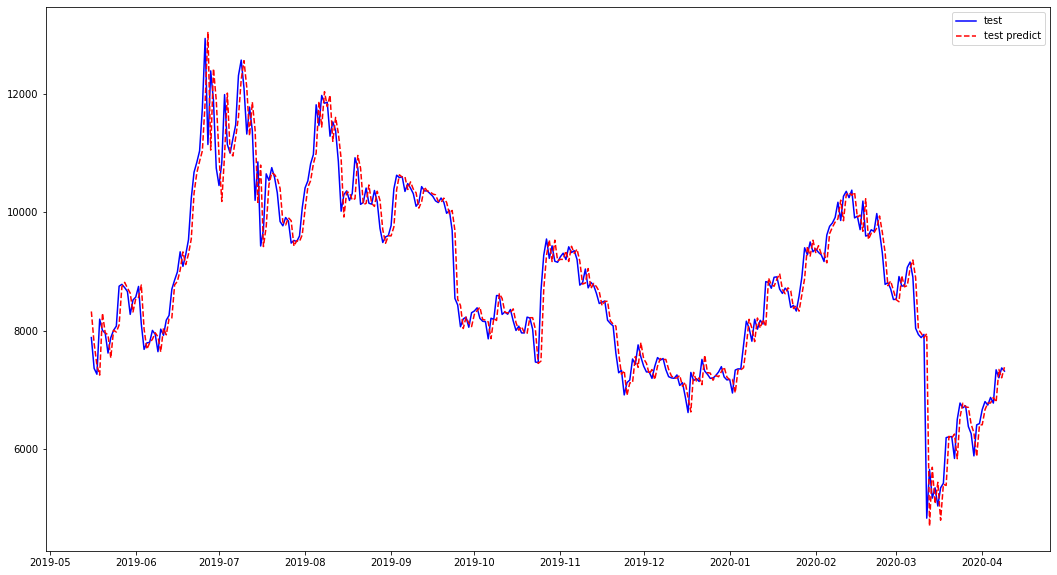

In [23]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '--', label = 'test predict', color="red")

ax.legend()
plt.show()

In [83]:
a = [2, 4, 16, 32, 64, 128, 256]
data = { 'a': a}
df_a = pd.DataFrame(data)
df_a['diff_1'] = df_a['a'].diff()
df_a['diff_2'] = df_a['diff_1'].diff()
df_a[:5]

a  diff_1  diff_2
0   2     NaN     NaN
1   4     2.0     NaN
2  16    12.0    10.0
3  32    16.0     4.0
4  64    32.0    16.0

In [85]:
last_close_price = df_a[:5]['a'].values[-1]
before_last_close_price = df_a[:5]['a'].values[-2]
last_close_diff_price = last_close_price - before_last_close_price
pred = last_close_price + last_close_diff_price + df_a[:6]['diff_2'].values[-1]
pred

128.0

In [20]:
df = df_gemini_price_d.copy()
df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

model = ARIMA(df[:'2019-04-30'], order=(1, 1, 0))
# print(df[:'2019-04-29'].index[-1])
print(df[:'2019-04-30'].index[-1])
fit_model = model.fit()

pred = fit_model.predict(start = '2019-04-30', end = '2019-04-30', dynamic = False)
pred

2019-04-30 00:00:00


Date
2019-04-30    3.370656
Freq: D, dtype: float64